In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial

In [2]:
__df = pd.read_csv('./data/spy-10y.csv')
__df.dtypes

Date           object
Close/Last    float64
Volume          int64
Open          float64
High          float64
Low           float64
dtype: object

In [3]:
__df['High'].apply(type).value_counts()

High
<class 'float'>    2516
Name: count, dtype: int64

In [4]:
__df['Low'].isna().sum()

np.int64(0)

In [5]:
def read_csv(filepath):
    print(f'parsing {filepath=}')
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])

    # Clean price columns by removing $ signs and converting to float.
    price_columns = ['Close/Last', 'Open', 'High', 'Low']
    for col in price_columns:
        if df[col].dtype != 'float64':
            print(f'cleaning {col=}')
            df[col] = df[col].str.replace('$', '').astype(float)

    # Sort by date (oldest first).
    # The reset and drop will make sure that the indices start from 0.
    # Otherwise the reordering will keep the same indices, so the first entry
    # would be something like 2511 (10 yrs ago).
    df = df.sort_values('Date').reset_index(drop=True)
    return df

In [6]:
def add_indicators(df):
    # Daily returns.
    df['Daily_Return'] = df['Close/Last'].pct_change()
    df.loc[0, 'Daily_Return'] = 0

    
    # Price range (High - Low).
    df['Daily_Range'] = df['High'] - df['Low']
    
    # Simple moving averages.
    df['SMA_20'] = df['Close/Last'].rolling(window=20).mean()
    df['SMA_50'] = df['Close/Last'].rolling(window=50).mean()
    df['SMA_200'] = df['Close/Last'].rolling(window=200).mean()
    df['SMA_400'] = df['Close/Last'].rolling(window=400).mean()

    # Bollinger Bands (typically 20-period with 2 standard deviations).
    df['BB_STD'] = df['Close/Last'].rolling(window=20).std()
    df['BB_Upper'] = df['SMA_20'] + (2 * df['BB_STD'])
    df['BB_Lower'] = df['SMA_20'] - (2 * df['BB_STD'])
    
    # Optional: %B indicator (where price sits within the bands).
    # 0 = at lower band, 1 = at upper band, >1 = above upper band.
    df['BB_Percent'] = (df['Close/Last'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

In [7]:
df_spy = read_csv('./data/spy-10y.csv')
df_cost = read_csv('./data/cost-10y.csv')

parsing filepath='./data/spy-10y.csv'
parsing filepath='./data/cost-10y.csv'
cleaning col='Close/Last'
cleaning col='Open'
cleaning col='High'
cleaning col='Low'


In [8]:
add_indicators(df_spy)
add_indicators(df_cost)

In [9]:
df_spy.head()

,Date,Close/Last,Volume,Open,High,Low,Daily_Return,Daily_Range,SMA_20,SMA_50,SMA_200,SMA_400,BB_STD,BB_Upper,BB_Lower,BB_Percent
0,2015-05-26,210.70,124074500,212.40,212.9089,210.2000,0.000000,2.7089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-05-27,212.70,92949380,211.25,212.9800,210.7612,0.009492,2.2188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-05-28,212.46,74855480,212.33,212.5900,211.6300,-0.001128,0.9600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-05-29,211.14,123383800,212.38,212.4300,210.8200,-0.006213,1.6100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-06-01,211.57,93171140,211.94,212.3400,210.6200,0.002037,1.7200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Quick gut check on the daily returns.
(df_spy.at[1, 'Close/Last'] / df_spy.at[0, 'Close/Last']) - 1

np.float64(0.009492168960607561)

In [11]:
df_cost.head()

,Date,Close/Last,Volume,Open,High,Low,Daily_Return,Daily_Range,SMA_20,SMA_50,SMA_200,SMA_400,BB_STD,BB_Upper,BB_Lower,BB_Percent
0,2015-05-26,143.25,2472652,144.08,144.410,143.08,0.000000,1.330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-05-27,145.42,2932013,143.63,145.640,143.11,0.015148,2.530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-05-28,144.26,3205852,144.32,145.970,143.16,-0.007977,2.810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-05-29,142.59,3026522,143.78,143.946,141.77,-0.011576,2.176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-06-01,142.39,2183313,143.05,143.250,141.90,-0.001403,1.350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Bollinger and stuff

In [12]:
def plot_bollinger_bands(df, symbol, days=60):
    recent_data = df.tail(days).copy()    
    # Strip time component from dates.
    recent_data['Date'] = pd.to_datetime(recent_data['Date']).dt.date
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create candlesticks.
    for i, (idx, row) in enumerate(recent_data.iterrows()):
        open_price = row['Open']
        close_price = row['Close/Last']
        high_price = row['High']
        low_price = row['Low']
        
        # Determine candle color.
        color = 'green' if close_price > open_price else 'red'
        
        # Draw the high-low line.
        ax.plot([i, i], [low_price, high_price], color=color, linewidth=1)
        
        # Draw the open-close rectangle.
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        rect = Rectangle((i-0.3, bottom), 0.6, height, 
                        facecolor=color, alpha=0.7, edgecolor=color)
        ax.add_patch(rect)
    
    # Moving averages.
    ax.plot(range(len(recent_data)), recent_data['SMA_20'], 
            label='SMA 20', color='red', linewidth=1.5)
    ax.plot(range(len(recent_data)), recent_data['SMA_50'], 
            label='SMA 50', color='green', linewidth=1.5)
    ax.plot(range(len(recent_data)), recent_data['SMA_200'], 
            label='SMA 200', color='black', linewidth=1.5)
    
    # Bollinger Bands.
    ax.plot(range(len(recent_data)), recent_data['BB_Upper'], 
            label='Upper Band', color='red', linestyle='--', alpha=0.7)
    ax.plot(range(len(recent_data)), recent_data['BB_Lower'], 
            label='Lower Band', color='green', linestyle='--', alpha=0.7)
    
    # Fill between bands.
    ax.fill_between(range(len(recent_data)), 
                    recent_data['BB_Lower'], 
                    recent_data['BB_Upper'], 
                    alpha=0.1, color='gray')

    # Format x-axis with dates.
    ax.set_xticks(range(0, len(recent_data), max(1, len(recent_data)//10)))
    ax.set_xticklabels([recent_data.iloc[i]['Date'] for i in 
                       range(0, len(recent_data), max(1, len(recent_data)//10))], 
                       rotation=45)
    
    ax.set_title(f'{symbol} Candlestick Chart with Bollinger Bands')
    ax.set_ylabel('Price ($)')
    ax.set_xlabel('Date')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

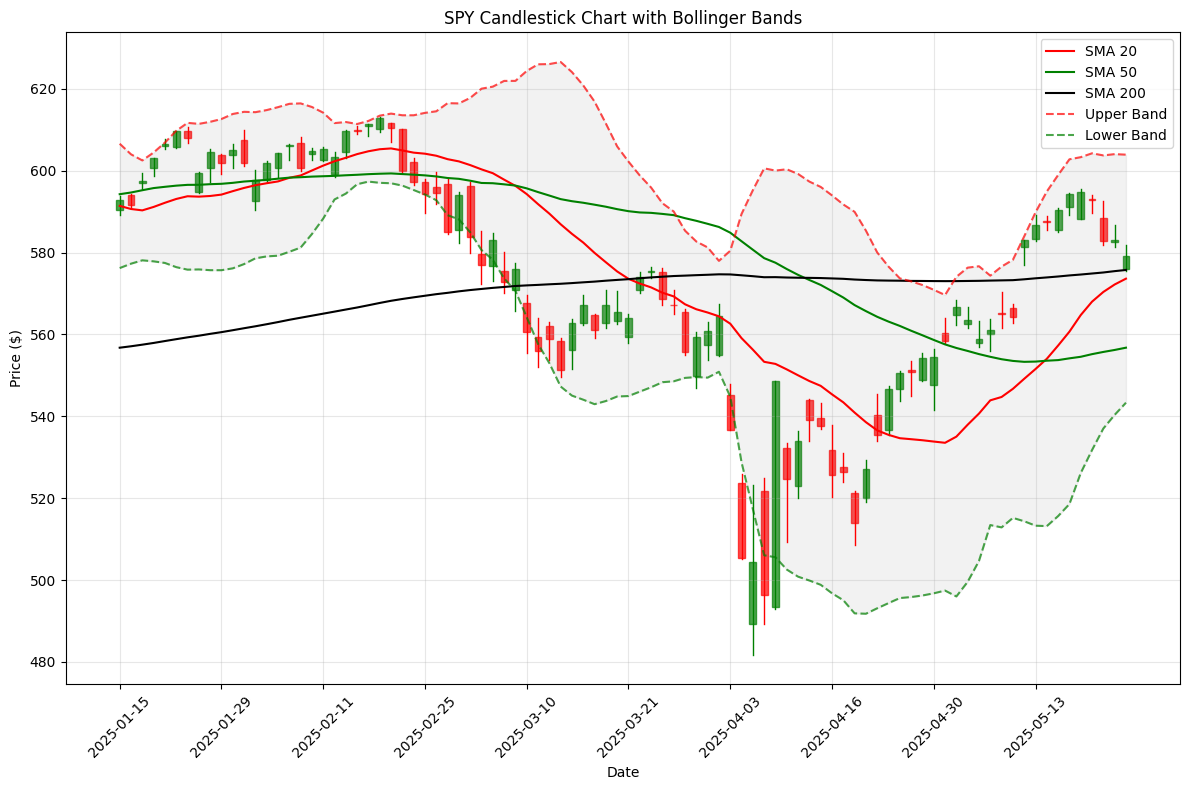

In [13]:
plot_bollinger_bands(df_spy, 'SPY', days=90)

In [14]:
def plot_bb_percent(df, symbol, days=60):
    """Plot price with Bollinger Bands and %B indicator"""
    recent_data = df.tail(days).copy()
    
    # Convert dates to matplotlib date format
    dates = mdates.date2num(pd.to_datetime(recent_data['Date']))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8),
        gridspec_kw={'height_ratios': [3, 2]},  # Make top plot 3x taller than bottom
        sharex=True)                            # Share x-axis

    # Create candlesticks using actual dates
    for i, (idx, row) in enumerate(recent_data.iterrows()):
        date_num = dates[i]
        open_price = row['Open']
        close_price = row['Close/Last']
        high_price = row['High']
        low_price = row['Low']
        
        # Determine candle color
        color = 'green' if close_price > open_price else 'red'
        
        # Draw the high-low line
        ax1.plot([date_num, date_num], [low_price, high_price], color=color, linewidth=1)
        
        # Draw the open-close rectangle
        width = 0.6  # Width in days
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)
        rect = Rectangle((date_num-width/2, bottom), width, height, 
                        facecolor=color, alpha=0.7, edgecolor=color)
        ax1.add_patch(rect)

    # Top plot: Moving averages and Bollinger Bands using dates
    ax1.plot(dates, recent_data['SMA_20'], 
             label='20-day SMA', color='red', linewidth=1)
    ax1.plot(dates, recent_data['SMA_200'], 
             label='200-day SMA', color='black', linewidth=1)
    ax1.plot(dates, recent_data['BB_Upper'], 
             label='Upper Band', color='red', linestyle='--', alpha=0.7)
    ax1.plot(dates, recent_data['BB_Lower'], 
             label='Lower Band', color='green', linestyle='--', alpha=0.7)
    ax1.fill_between(dates, recent_data['BB_Lower'], 
                     recent_data['BB_Upper'], alpha=0.1, color='gray')
    
    ax1.set_title(f'{symbol} Price with Bollinger Bands')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: %B with reference lines using dates
    ax2.plot(dates, recent_data['BB_Percent'], 
             color='purple', linewidth=2)
    
    # Reference lines for interpretation
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(y=0, color='green', linestyle='--', alpha=0.7)
    ax2.axhline(y=0.5, color='black', linestyle='-', alpha=0.5)
    
    # Color coding zones - use full date range
    date_min, date_max = dates.min(), dates.max()
    ax2.fill_between([date_min, date_max], [0.8, 0.8], [1.2, 1.2], 
                     alpha=0.2, color='red', label='Overbought Zone')
    ax2.fill_between([date_min, date_max], [-0.2, -0.2], [0.2, 0.2], 
                     alpha=0.2, color='green', label='Oversold Zone')
    
    ax2.set_title('%B Indicator (Position within Bollinger Bands)')
    ax2.set_ylabel('%B')
    ax2.set_xlabel('Date')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    # Format x-axis to show only dates
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, days//10)))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

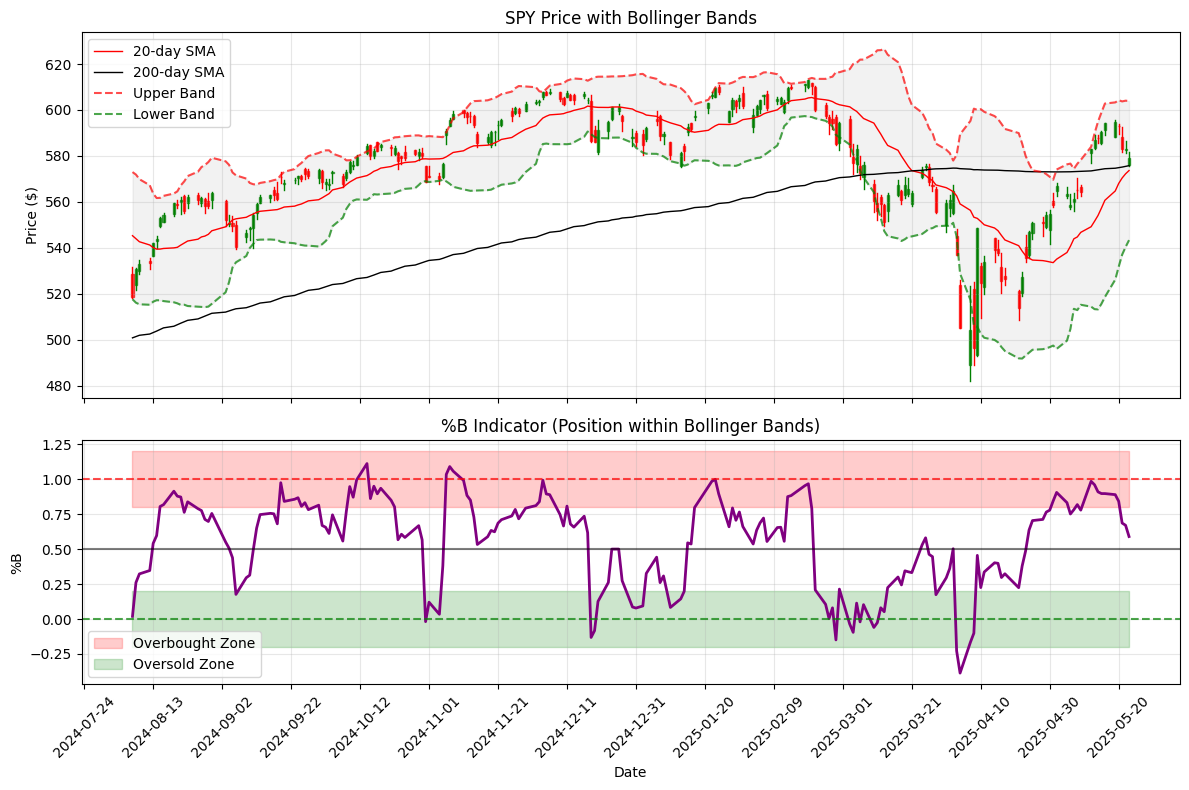

In [15]:
plot_bb_percent(df_spy, 'SPY', days=200)

In [16]:
def plot_bb_percent_scatter(df, symbol, days=120):
    """Scatter plot showing %B vs price returns with color coding"""
    recent_data = df.tail(days)
    
    plt.figure(figsize=(6, 4))
    
    # Color points based on %B value.
    colors = []
    for bb_pct in recent_data['BB_Percent']:
        if bb_pct > 0.8:
            colors.append('red')      # Overbought
        elif bb_pct < 0.2:
            colors.append('green')    # Oversold
        else:
            colors.append('blue')     # Normal
    
    plt.scatter(recent_data['BB_Percent'], recent_data['Daily_Return'] * 100, 
                c=colors, alpha=0.6, s=50)
    
    # Reference lines.
    plt.axvline(x=0, color='green', linestyle='--', alpha=0.7, label='Lower Band')
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Upper Band') 
    plt.axvline(x=0.5, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.xlabel('%B (Position within Bollinger Bands)')
    plt.ylabel('Daily Return (%)')
    plt.title(f'{symbol}: %B vs Daily Returns')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

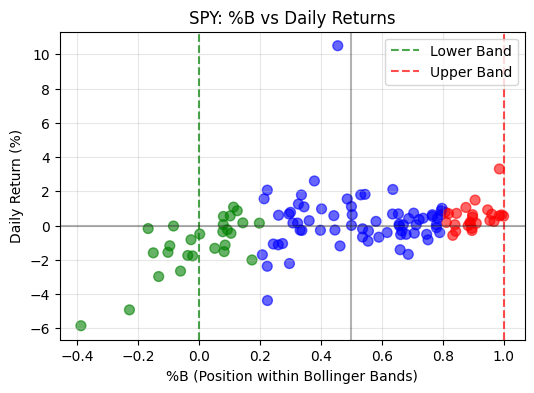

In [17]:
plot_bb_percent_scatter(df_spy, 'SPY')

In [35]:
def plot_bb_percent_histogram(df, symbol):
    """Show distribution of %B values"""
    plt.figure(figsize=(6, 4))
    
    # Histogram
    plt.hist(df['BB_Percent'], bins=60, alpha=0.7, color='lightblue', edgecolor='black')
    
    # Reference lines
    plt.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Lower Band (0.0)')
    plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Upper Band (1.0)')
    plt.axvline(x=0.5, color='black', linestyle='-', linewidth=1)
    
    plt.xlabel('%B Value')
    plt.ylabel('Frequency')
    plt.title(f'{symbol}: Distribution of %B Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add some stats
    mean_bb = df['BB_Percent'].mean()
    plt.text(0.02, plt.ylim()[1] * 0.9, f'Mean %B: {mean_bb:.3f}', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.show()

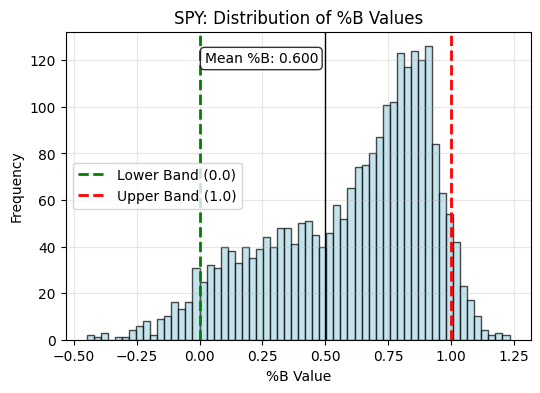

In [36]:
plot_bb_percent_histogram(df_spy, 'SPY')

In [33]:
def analyze_returns_relationship(
    df1, df2,
    name1="Asset 1", name2="Asset 2", 
    alpha=0.05, figsize=(12, 8)
):
    # Extract daily returns and align by date.
    returns1 = df1[['Date', 'Daily_Return']].copy()
    returns2 = df2[['Date', 'Daily_Return']].copy()
    
    # Ensure Date columns are datetime.
    returns1['Date'] = pd.to_datetime(returns1['Date'])
    returns2['Date'] = pd.to_datetime(returns2['Date'])
    
    # Merge on date to get overlapping periods.
    merged = pd.merge(returns1, returns2, on='Date', suffixes=('_1', '_2'))
    
    # Remove NaN values.
    merged = merged.dropna()
    
    if len(merged) < 2:
        raise ValueError("Not enough overlapping data points for analysis")
    
    x = merged['Daily_Return_1'].values
    y = merged['Daily_Return_2'].values
    
    # Linear regression with numpy polynomial API.
    poly = Polynomial.fit(x, y, deg=1)
    alpha_reg, beta = poly.coef  # coef order: [intercept, slope]
    y_pred = poly(x)
    r_squared = np.corrcoef(x, y)[0, 1]**2
    
    # Covariance and correlation.
    # See
    # https://github.com/seafoodfry/numerical-analysis/blob/main/stats/basics/00-covariance.ipynb
    covariance = np.cov(x, y)[0, 1]
    
    # Hypothesis test for correlation using scipy.
    correlation, p_value = stats.pearsonr(x, y)
    
    # Create the plot.
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scatterplot with regression line
    ax.scatter(x, y, alpha=0.6, color='steelblue', s=30)
    
    # Add regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = poly(x_line)
    ax.plot(x_line, y_line, 'r-', linewidth=2, 
             label=f'y = {alpha_reg:.4f} + {beta:.4f}x')
    
    ax.set_xlabel(f'{name1} Daily Returns')
    ax.set_ylabel(f'{name2} Daily Returns')
    ax.set_title(f'Daily Returns Relationship\n{name1} vs {name2}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add correlation text
    ax.text(0.05, 0.95, f'Correlation: {correlation:.4f}\nR²: {r_squared:.4f}', 
             transform=ax.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print results.
    n = len(x)
    print("=" * 60)
    print(f"ANALYSIS RESULTS: {name1} vs {name2}")
    print("=" * 60)
    print(f"Data Points: {n}")
    print(f"Date Range: {merged['Date'].min().strftime('%Y-%m-%d')} to {merged['Date'].max().strftime('%Y-%m-%d')}")
    print()
    
    print("LINEAR REGRESSION RESULTS:")
    print(f"  Alpha (Intercept): {alpha_reg:.3f}")
    print(f"  Beta (Slope):      {beta:.3f}")
    print(f"  R-squared:         {r_squared:.6f}")
    print()
    
    print("CORRELATION & COVARIANCE:")
    print(f"  Correlation:       {correlation:.6f}")
    print(f"  Covariance:        {covariance:.6f}")
    print()
    
    print("HYPOTHESIS TEST FOR CORRELATION:")
    print(f"  H0: ρ = 0 (no linear relationship)")
    print(f"  H1: ρ ≠ 0 (linear relationship exists)")
    print(f"  P-value:           {p_value:.6f}")
    print(f"  Significance (α):  {alpha}")
    
    if p_value < alpha:
        print(f"  Result: REJECT H0 (significant relationship at α={alpha})")
    else:
        print(f"  Result: FAIL TO REJECT H0 (no significant relationship at α={alpha})")

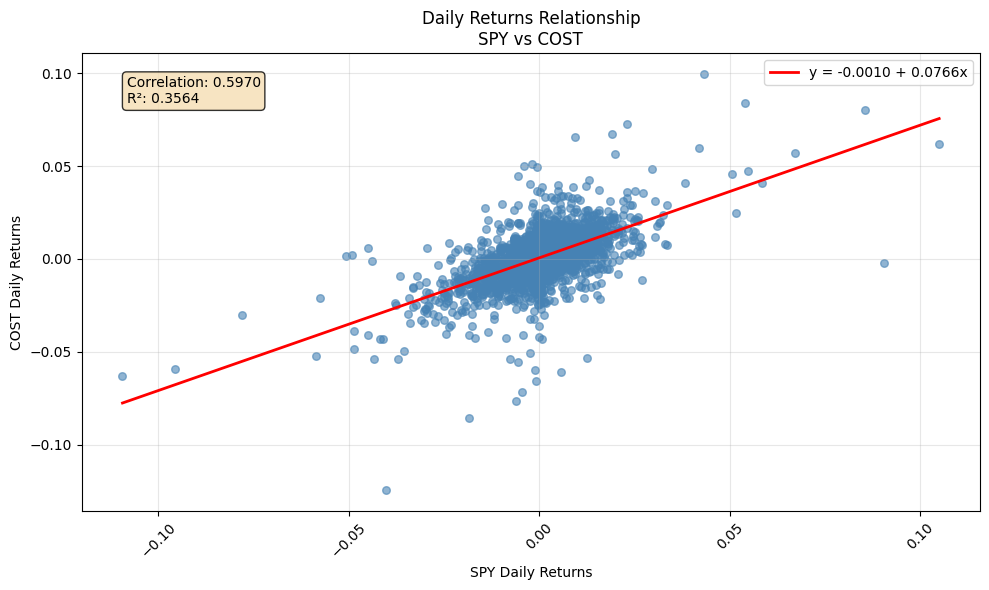

ANALYSIS RESULTS: SPY vs COST
Data Points: 2516
Date Range: 2015-05-26 to 2025-05-23

LINEAR REGRESSION RESULTS:
  Alpha (Intercept): -0.001
  Beta (Slope):      0.077
  R-squared:         0.356368

CORRELATION & COVARIANCE:
  Correlation:       0.596965
  Covariance:        0.000096

HYPOTHESIS TEST FOR CORRELATION:
  H0: ρ = 0 (no linear relationship)
  H1: ρ ≠ 0 (linear relationship exists)
  P-value:           0.000000
  Significance (α):  0.05
  Result: REJECT H0 (significant relationship at α=0.05)


In [34]:
analyze_returns_relationship(df_spy, df_cost, name1='SPY', name2='COST', figsize=(10,6))

**R-squared (correlation coefficient squared)** of 0.356 tells you what percentage of variance in COST is explained by SPY.
How much of COST's ups and downs can you predict/account for using SPY.
It's about predictive power, not just association.
So not a whole lot.

In regression context, it's literally how much better your model (with X=SPY) performs compared to just using the mean of Y(=COST) as your prediction.

---

**Correlation coefficient (Pearson's r)**

Ranges from -1 to +1.
Tells you strength AND direction of linear relationship.

---

**Covariance**

Can be any value (positive, negative, or zero).
Tells you direction of relationship but hard to interpret the magnitude.
* Positive = tend to move in same direction
* Negative = tend to move in opposite directions
* Problem: units depend on the scale of your data (daily returns vs. percentages vs. dollars)

Correlation is just standardized covariance!
correlation = covariance / (std_dev_x * std_dev_y)